## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2
from keras.layers import Dropout
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4,  drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
            
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
Dropout_EXP = 0.25 
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256

50000/50000 [==============================] - 5s 94us/step - loss: 2.3303 - acc: 0.2454 - val_loss: 2.4613 - val_acc: 0.1815
Epoch 47/50
50000/50000 [==============================] - 5s 92us/step - loss: 2.3525 - acc: 0.2298 - val_loss: 2.5558 - val_acc: 0.1751
Epoch 48/50
50000/50000 [==============================] - 5s 98us/step - loss: 2.3233 - acc: 0.2454 - val_loss: 2.4208 - val_acc: 0.2197
Epoch 49/50
50000/50000 [==============================] - 5s 92us/step - loss: 2.3481 - acc: 0.2295 - val_loss: 2.3606 - val_acc: 0.2188
Epoch 50/50
50000/50000 [==============================] - 5s 91us/step - loss: 2.3290 - acc: 0.2415 - val_loss: 2.3978 - val_acc: 0.1728
Experiment with Regulizer = 0.000100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)

Epoch 42/50
50000/50000 [==============================] - 5s 97us/step - loss: 3.1791 - acc: 0.4993 - val_loss: 3.2317 - val_acc: 0.4707
Epoch 43/50
50000/50000 [==============================] - 5s 95us/step - loss: 3.1405 - acc: 0.5002 - val_loss: 3.1594 - val_acc: 0.4863
Epoch 44/50
50000/50000 [==============================] - 5s 97us/step - loss: 3.0988 - acc: 0.5022 - val_loss: 3.1189 - val_acc: 0.4880
Epoch 45/50
50000/50000 [==============================] - 5s 93us/step - loss: 3.0549 - acc: 0.5025 - val_loss: 3.1010 - val_acc: 0.4787
Epoch 46/50
50000/50000 [==============================] - 5s 94us/step - loss: 3.0046 - acc: 0.5073 - val_loss: 3.0519 - val_acc: 0.4826
Epoch 47/50
50000/50000 [==============================] - 5s 96us/step - loss: 2.9776 - acc: 0.5031 - val_loss: 3.0274 - val_acc: 0.4816
Epoch 48/50
50000/50000 [==============================] - 5s 93us/step - loss: 2.9397 - acc: 0.5051 - val_loss: 3.0129 - val_acc: 0.4660
Epoch 49/50
50000/50000 [=========

50000/50000 [==============================] - 5s 103us/step - loss: 1.3150 - acc: 0.5268 - val_loss: 1.3973 - val_acc: 0.5066
Epoch 38/50
50000/50000 [==============================] - 5s 100us/step - loss: 1.3090 - acc: 0.5316 - val_loss: 1.3394 - val_acc: 0.5224
Epoch 39/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.3020 - acc: 0.5327 - val_loss: 1.3626 - val_acc: 0.5112
Epoch 40/50
50000/50000 [==============================] - 5s 100us/step - loss: 1.2995 - acc: 0.5327 - val_loss: 1.3703 - val_acc: 0.5094
Epoch 41/50
50000/50000 [==============================] - 6s 116us/step - loss: 1.2979 - acc: 0.5346 - val_loss: 1.3518 - val_acc: 0.5139
Epoch 42/50
50000/50000 [==============================] - 6s 118us/step - loss: 1.2904 - acc: 0.5378 - val_loss: 1.3496 - val_acc: 0.5193
Epoch 43/50
50000/50000 [==============================] - 6s 114us/step - loss: 1.2936 - acc: 0.5359 - val_loss: 1.3632 - val_acc: 0.5153
Epoch 44/50
50000/50000 [==============

50000/50000 [==============================] - 5s 91us/step - loss: 1.3533 - acc: 0.5144 - val_loss: 1.4012 - val_acc: 0.4947
Epoch 33/50
50000/50000 [==============================] - 5s 91us/step - loss: 1.3465 - acc: 0.5159 - val_loss: 1.3803 - val_acc: 0.5037
Epoch 34/50
50000/50000 [==============================] - 5s 91us/step - loss: 1.3316 - acc: 0.5206 - val_loss: 1.3614 - val_acc: 0.5108
Epoch 35/50
50000/50000 [==============================] - 5s 95us/step - loss: 1.3292 - acc: 0.5214 - val_loss: 1.3919 - val_acc: 0.4992
Epoch 36/50
50000/50000 [==============================] - 5s 93us/step - loss: 1.3216 - acc: 0.5251 - val_loss: 1.3683 - val_acc: 0.5083
Epoch 37/50
50000/50000 [==============================] - 5s 91us/step - loss: 1.3180 - acc: 0.5262 - val_loss: 1.3943 - val_acc: 0.5006
Epoch 38/50
50000/50000 [==============================] - 5s 91us/step - loss: 1.3134 - acc: 0.5264 - val_loss: 1.3907 - val_acc: 0.5073
Epoch 39/50
50000/50000 [=====================

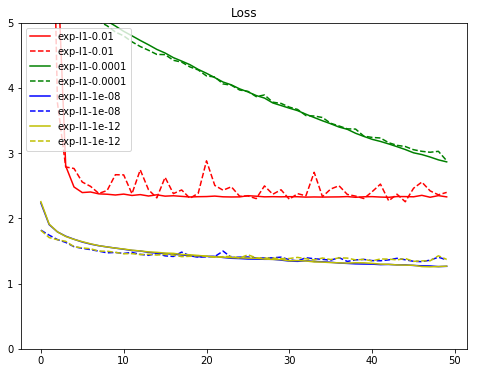

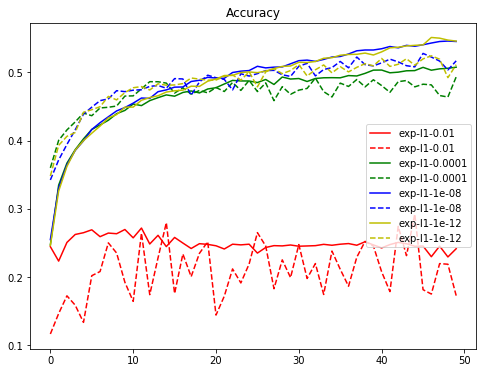

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()